In [79]:
import os
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

/tmp/ipykernel_10084/3487689122.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [75]:
# Helper to get all timepoints and years from a yieldstudy
def get_yieldstudy_dirs(basedir):
    year_dirs = [os.path.join(basedir, f) for f in sorted(os.listdir(basedir)) if os.path.isdir(os.path.join(basedir, f))]
    timepoint_dirs = [os.path.join(year_dir, f) for year_dir in year_dirs for f in sorted(os.listdir(year_dir)) if os.path.isdir(os.path.join(year_dir, f))]
    return {
        'years': year_dirs,
        'timepoints': timepoint_dirs
    }

In [72]:
# Helper to get insights into the matching process
def get_matching_stats(timepoint_dir):
    results = []
    drought_regions = 0
    for dir in os.listdir(timepoint_dir):
        if os.path.isdir(os.path.join(timepoint_dir, dir)):
            field_dir = os.path.join(timepoint_dir, dir)
            matching_file = os.path.join(field_dir, f'{dir}_sim_matches.csv')
            df = pd.read_csv(matching_file)
            results.append(df)
            if (df['StepFilteredOut'] == 1).any():
                # as soon as one simulation was filtered out at step 1 it musth have been a drought
                drought_regions += 1
    
    # compute frequency of values in the 'StepFilteredOut' column
    df = pd.concat(results)
    freq = df['StepFilteredOut'].value_counts()
    percentage = freq / freq.sum() * 100
    return {
        'frequencies': freq.sort_index(),
        'percentages': percentage.sort_index(),
        'regions_with_drought': drought_regions
    }

In [55]:
def get_cloud_stats(timepoint_dir):
    results = []
    num_days_valid_rs = []
    days_less_than_50percent_coverage = []
    for dir in os.listdir(timepoint_dir):
        if os.path.isdir(os.path.join(timepoint_dir, dir)):
            field_dir = os.path.join(timepoint_dir, dir)
            LAI_file = os.path.join(field_dir, f'{dir}_LAI_STATS.csv')
            df = pd.read_csv(LAI_file)
            filtered_df = df[df['Cloud or Snow Percentage'] < 100]['Cloud or Snow Percentage']
            num_days_valid_rs.append(len(filtered_df))
            days_less_than_50percent_coverage.append(len(df[df['Cloud or Snow Percentage'] < 50]))
            results.append(filtered_df.mean())
    return {'mean_cloudcoverage_percent': np.mean(results), 'mean_valid_rs_days': np.mean(num_days_valid_rs), 'mean_days_less_than_50percent_coverage': np.mean(days_less_than_50percent_coverage)} 
    

In [81]:
def plot_rs_curves(timepoint_dir):
    plt.figure(figsize=(10, 6))  # Set up the plot size

    for dir in os.listdir(timepoint_dir):
        if os.path.isdir(os.path.join(timepoint_dir, dir)):
            field_dir = os.path.join(timepoint_dir, dir)
            LAI_file = os.path.join(field_dir, f'{dir}_LAI_STATS.csv')

            if os.path.exists(LAI_file):
                df = pd.read_csv(LAI_file, index_col='Date', parse_dates=['Date'], dayfirst=True)

                df.index = pd.to_datetime(df.index)  # Try parsing as dates
                df = df.sort_index()

                plt.plot(df.index, df['LAI Mean Adjusted'], label=dir)

    plt.xlabel('Date or Index')
    plt.ylabel('LAI Mean Adjusted')
    plt.title('Remotely Sensed LAI Curves for All Regions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/el_hajeb_chirps-APSIM-18-03/2019/T-0
{'mean_cloudcoverage_percent': np.float64(18.334121287142686),
 'mean_days_less_than_50percent_coverage': np.float64(40.36842105263158),
 'mean_valid_rs_days': np.float64(51.421052631578945)}
{'frequencies': StepFilteredOut
1.0     7770
2.0    33068
3.0     7194
4.0      940
5.0      160
Name: count, dtype: int64,
 'percentages': StepFilteredOut
1.0    15.814540
2.0    67.304404
3.0    14.642188
4.0     1.913213
5.0     0.325653
Name: count, dtype: float64,
 'regions_with_drought': 3}


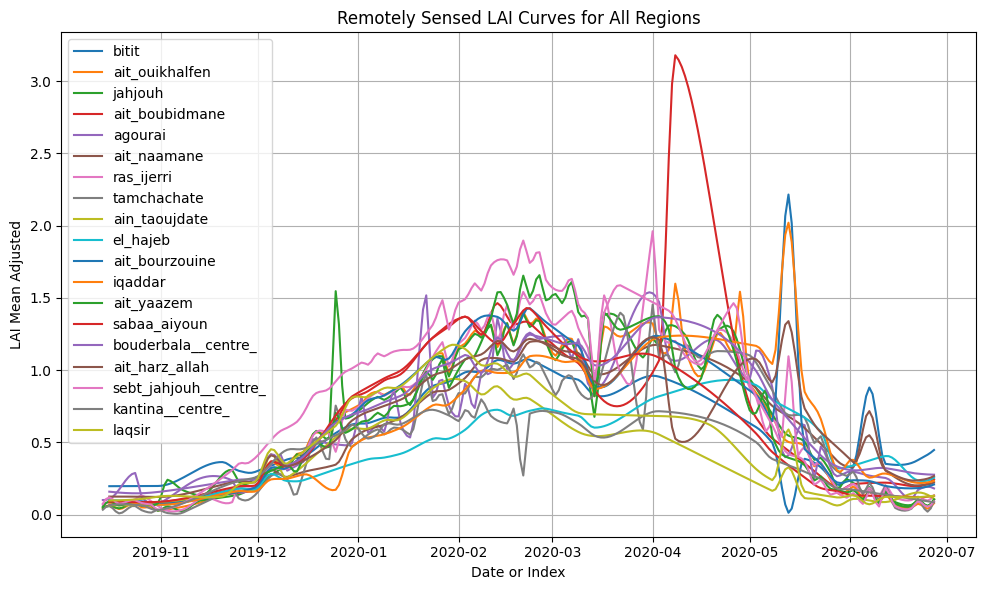

-------------------
/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/el_hajeb_chirps-APSIM-18-03/2023/T-0
{'mean_cloudcoverage_percent': np.float64(16.83042092453969),
 'mean_days_less_than_50percent_coverage': np.float64(44.36842105263158),
 'mean_valid_rs_days': np.float64(54.63157894736842)}
{'frequencies': StepFilteredOut
1.0     2590
2.0    37264
3.0     8768
4.0      498
5.0       64
Name: count, dtype: int64,
 'percentages': StepFilteredOut
1.0     5.265940
2.0    75.764476
3.0    17.826936
4.0     1.012524
5.0     0.130124
Name: count, dtype: float64,
 'regions_with_drought': 1}


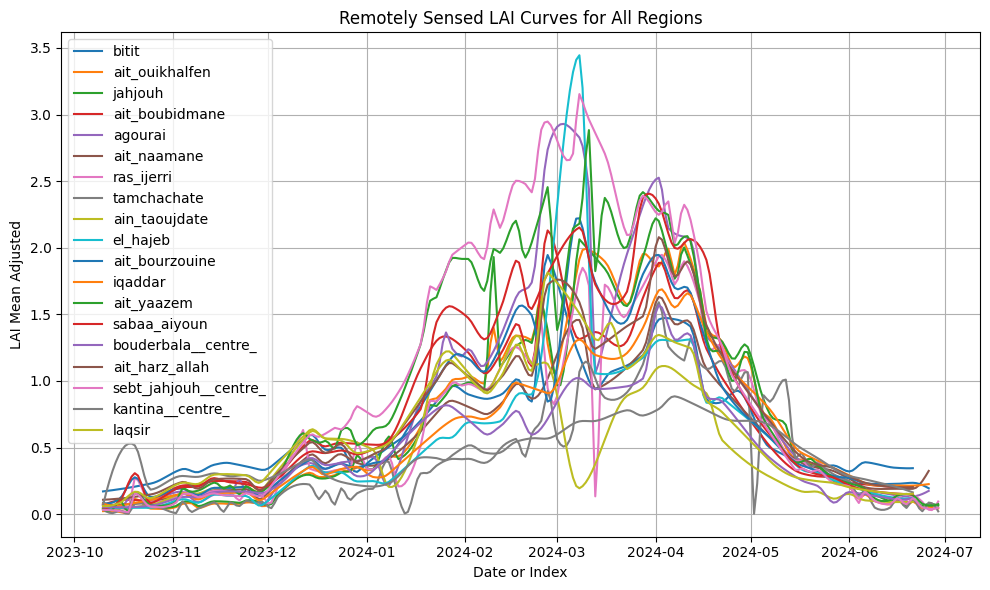

-------------------
/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/el_hajeb_chirps-APSIM-18-03/2024/T-0
{'mean_cloudcoverage_percent': np.float64(20.02552020628467),
 'mean_days_less_than_50percent_coverage': np.float64(23.526315789473685),
 'mean_valid_rs_days': np.float64(30.0)}
{'frequencies': StepFilteredOut
1.0    12950
2.0    28962
3.0     6854
4.0      334
5.0       50
Name: count, dtype: int64,
 'percentages': StepFilteredOut
1.0    26.347915
2.0    58.925738
3.0    13.945066
4.0     0.679552
5.0     0.101729
Name: count, dtype: float64,
 'regions_with_drought': 5}


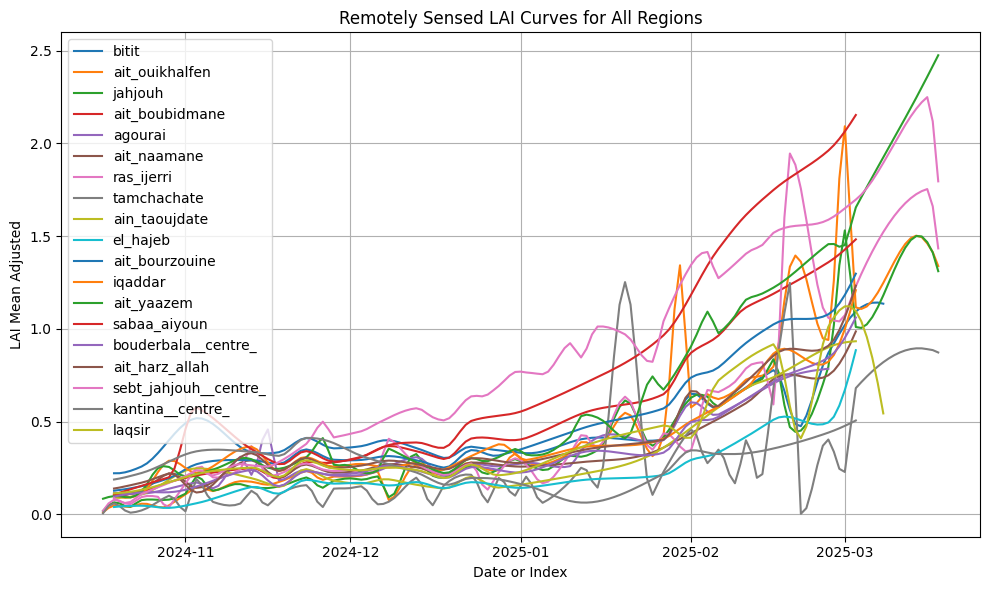

-------------------


In [82]:
# Run you analysis here
basedir = '/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/el_hajeb_chirps-APSIM-18-03'
for timepoint_dir in get_yieldstudy_dirs(basedir)['timepoints']:
    print(timepoint_dir)
    pprint(get_cloud_stats(timepoint_dir))
    pprint(get_matching_stats(timepoint_dir))
    plot_rs_curves(timepoint_dir)
    print('-------------------')

/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/settat_chirps-APSIM-18-03/2019/T-0
{'mean_cloudcoverage_percent': np.float64(17.63273625644495),
 'mean_days_less_than_50percent_coverage': np.float64(40.48979591836735),
 'mean_valid_rs_days': np.float64(49.42857142857143)}
{'frequencies': StepFilteredOut
1.0    36260
2.0    72125
3.0    14772
4.0     2967
5.0      618
Name: count, dtype: int64,
 'percentages': StepFilteredOut
1.0    28.609301
2.0    56.906945
3.0    11.655174
4.0     2.340976
5.0     0.487605
Name: count, dtype: float64,
 'regions_with_drought': 14}


/tmp/ipykernel_10084/3315550529.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


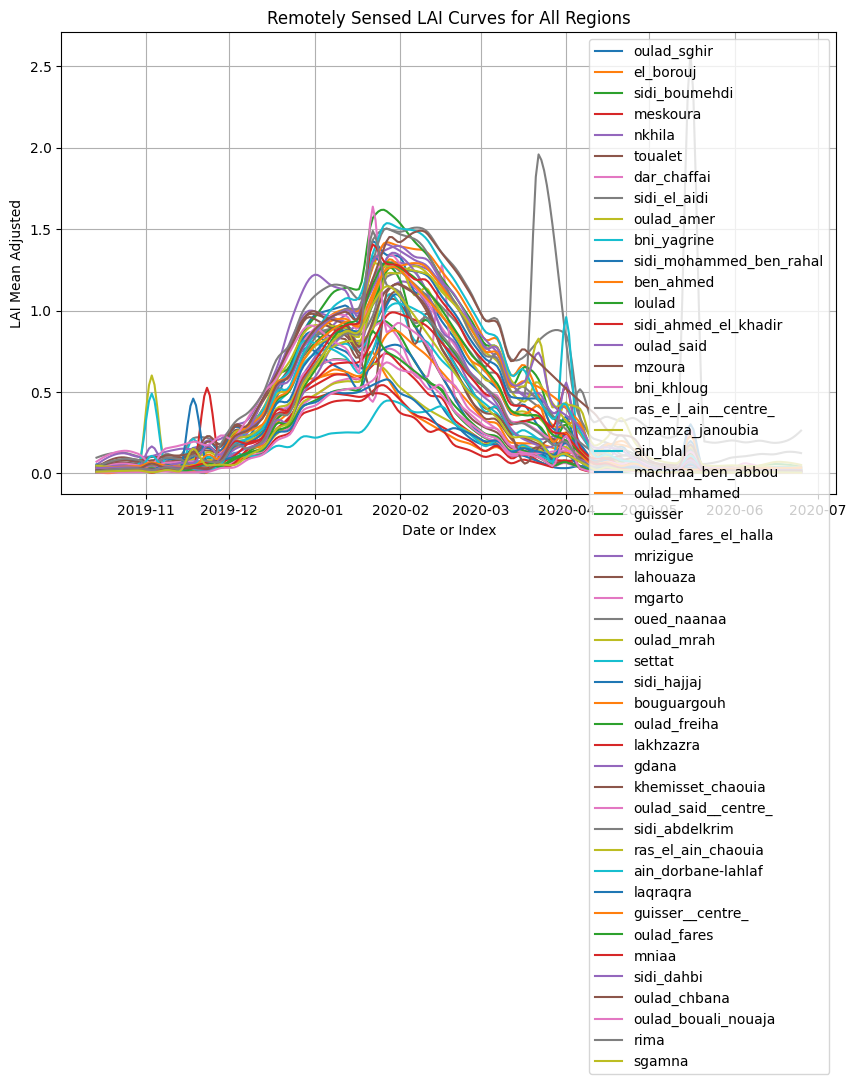

-------------------
/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/settat_chirps-APSIM-18-03/2023/T-0
{'mean_cloudcoverage_percent': np.float64(19.87455907864848),
 'mean_days_less_than_50percent_coverage': np.float64(33.55102040816327),
 'mean_valid_rs_days': np.float64(42.265306122448976)}
{'frequencies': StepFilteredOut
1.0    95830
2.0    24804
3.0     4840
4.0     1136
5.0      220
Name: count, dtype: int64,
 'percentages': StepFilteredOut
1.0    75.557833
2.0    19.556887
3.0     3.816132
4.0     0.895687
5.0     0.173461
Name: count, dtype: float64,
 'regions_with_drought': 37}


/tmp/ipykernel_10084/3315550529.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


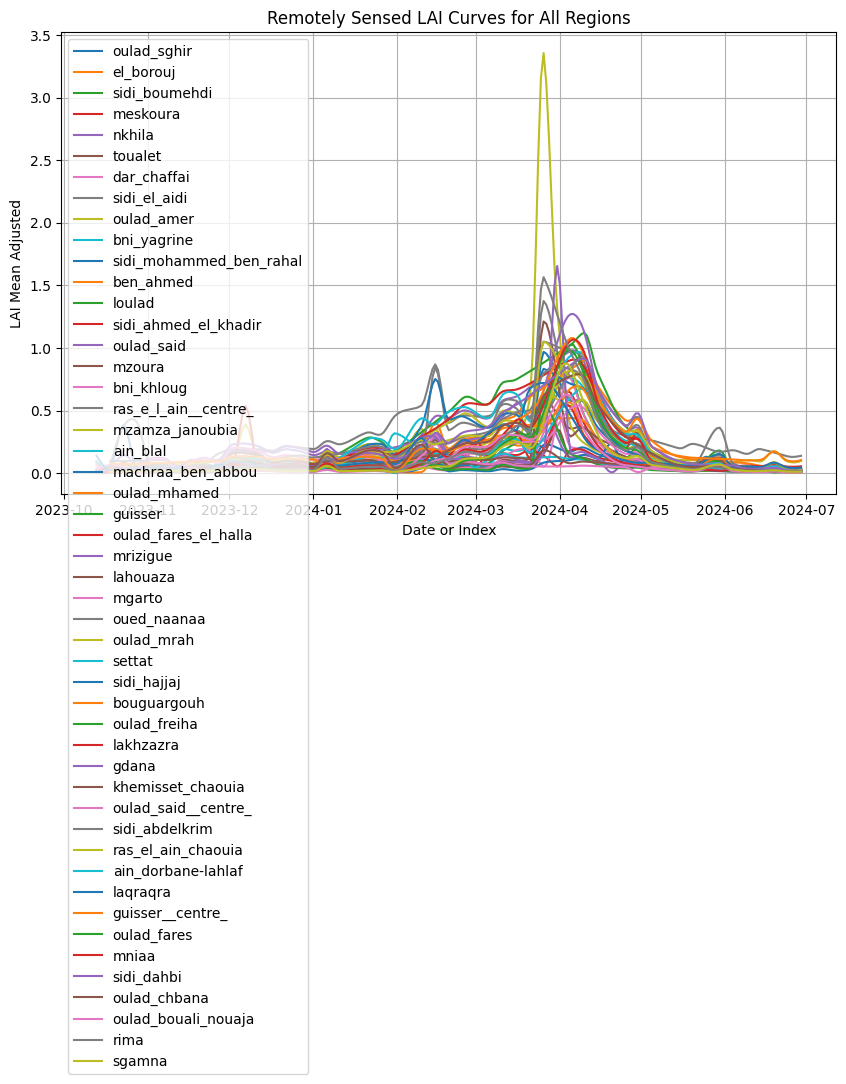

-------------------
/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/settat_chirps-APSIM-18-03/2024/T-0
{'mean_cloudcoverage_percent': np.float64(21.21416789660805),
 'mean_days_less_than_50percent_coverage': np.float64(18.408163265306122),
 'mean_valid_rs_days': np.float64(23.653061224489797)}
{'frequencies': StepFilteredOut
1.0    124320
2.0      2069
3.0       476
4.0        32
5.0         8
Name: count, dtype: int64,
 'percentages': StepFilteredOut
1.0    97.963043
2.0     1.630353
3.0     0.375084
4.0     0.025216
5.0     0.006304
Name: count, dtype: float64,
 'regions_with_drought': 48}


/tmp/ipykernel_10084/3315550529.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


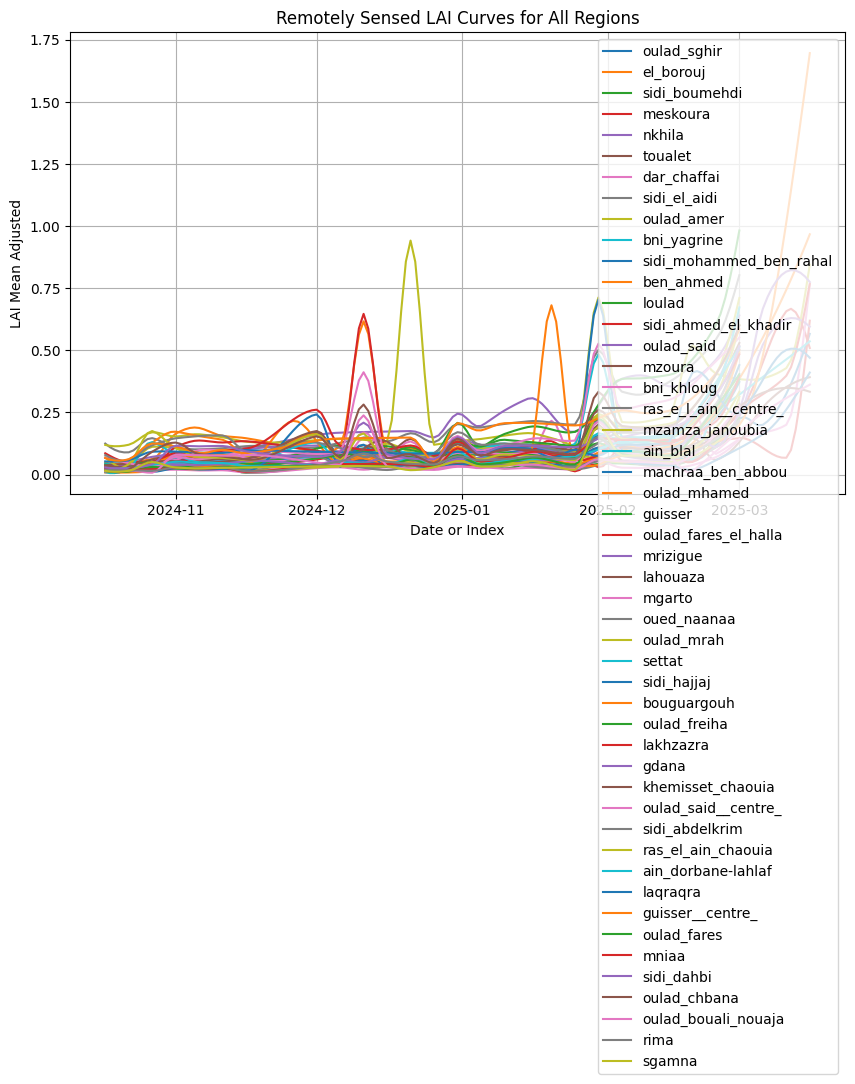

-------------------


In [83]:
# Run you analysis here
basedir = '/gpfs/data1/cmongp2/sawahnr/data/morocco/vercye_runs/settat_chirps-APSIM-18-03'
for timepoint_dir in get_yieldstudy_dirs(basedir)['timepoints']:
    print(timepoint_dir)
    pprint(get_cloud_stats(timepoint_dir))
    pprint(get_matching_stats(timepoint_dir))
    plot_rs_curves(timepoint_dir)
    print('-------------------')